# Workshop от Яндекс.Практикум и Samokat.tech на [Kaggle](https://www.kaggle.com/competitions/samokattechworkshop)

## Описание проекта

**Задача:** реализовать усеченную задачу матчинга - найти в базе (base) 10 объектов близких по признакам 1 объекту из запроса (query).

**Описание:** в базе данных (base) хранится информация о продуктах, которые могут быть предложены для покупки. Запрос (query) представляет из себя набор конкретных продуктов, для которых необходимо найти соответствие в базе данных. Задача состоит в том, чтобы автоматически сопоставить запрос с подходящим элементом из базы данных и предоставить пользователю наиболее релевантный результат. Это позволяет снизить дублирование товаров и упростить процесс управления продуктами, что способствует увеличению эффективности и экономии времени.

**Метрика:** Метрикой в данной задаче является Recall@10. Для каждого товара находим 10 наиболее близких кандидатов. Тогда:

**Recall@10 = (общая сумма найденных в топ10 матчей) / (общая сумма матчей)**

Ссылка на соревнование: [Kaggle](https://www.kaggle.com/competitions/samokattechworkshop)

Ссылка на мой профиль Kaggle: [fit2predict](https://www.kaggle.com/fit2predict)

**С какими сложностями столкнулся?**

⚠️ Признаки представлены в виде чисел, названия не приведены, что затрудняет понимание предмета запроса и того, с чем мы работаем;

⚠️ В числе признаков есть векторизованные изображения (какие мы не знаем);

⚠️ В таблицы исходных данных были добавлены "мусорные" признаки, которые никак не связаны с задачей (спойлер: найти их было не так сложно);

⚠️ В тренировочном наборе для нахождения соответствия в Target приведен один объект, а для теста было необходимо найти 10.

**Что сработало и повысило метрику?**

✅ Стандартизация признаков с помощью StandardScaler (центрирование относительно мат. ожидания и масштабирование по ср. квадратичному отклонению);

✅ Векторный поиск с помощью бибилиотеки FAISS (ссылка на доп. материалы ниже);

✅ Исключение признаков с распределением, отличным от нормального;

✅ Классификации объектов RandomForest для многоступенчатого поиска по нескольким индексам (включая отброшенные признаки).

**Что понижало метрику и не сработало?**

⛔️ Нелинейные преобразования признаков - QuantileTransformer и PowerTransformer;

⛔️ Варианты центрирования признаков относительно медианы или моды, а также смещения по вектору с помощью линейной регрессии;

⛔️ Методы понижения размерности признакового пространства PCA.

**Что можно сделать, чтобы улучшить результат?**

🌱 Заменить RandomForest на что-то лучшее (посмотреть в сторону бустинговых моделей), подобрать гиперпараметры;

🌱 Подобрать лучшие пороги для классификации к какому индексу относить объекты;

🌱 Перейти от задачи классификации к задаче регрессии, если классы представить в виде матрицы бинарных состояний;

🌱 Добавить реранкинг с помощью ML (ссылка для ознакомления ниже).

В базе данных ~3 млн. строк и была использована зарекомендовавшая себя реализация векторного поиска FAISS:

https://github.com/facebookresearch/faiss/wiki

https://habr.com/ru/companies/okkamgroup/articles/509204/

https://habr.com/ru/companies/ozontech/articles/648231/

https://www.youtube.com/watch?v=F7RG-M2PCKo&ab_channel=AliTech

Логичным продолжением и совершенствованием результатов FAISS будет реранкинг с помощью ML, например CatBoost:

https://github.com/catboost/catboost/blob/master/catboost/tutorials/ranking/ranking_tutorial.ipynb

## Содержание работы:
1. [Импорт библиотек](#Импорт-библиотек)
1. [Загрузка и обзор данных](#Загрузка-и-обзор-данных)
1. [Анализ распределения признаков](#Анализ-распределения-признаков)
1. [Подготовка данных](#Подготовка-данных)
1. [Baseline на обучающей выборке](#Baseline-на-обучающей-выборке)
1. [Поиск по сокращенному набору признаков (Recall@10 на тестовой выборке = 0.73730)](#Поиск-по-сокращенному-набору-признаков-(Recall@10-на-тестовой-выборке-=-0.73730))
1. [Многоступенчатый поиск по нескольким индексам (Recall@10 на тестовой выборке = 0.75970)](#Многоступенчатый-поиск-по-нескольким-индексам-(Recall@10-на-тестовой-выборке-=-0.75970))
1. [Формирование тестовой выгрузки](#Формирование-тестовой-выгрузки)

## Импорт библиотек

In [1]:
import os
import joblib
from collections import defaultdict
from IPython.display import IFrame, Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

try:
    import faiss
except ModuleNotFoundError:
    !pip install faiss-cpu --quiet
    import faiss

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RECOUNT_NOTEBOOK = False
RANDOM_SEED = 12345
DATA_DIR = '/kaggle/input/samokattechworkshop/'

In [3]:
np.random.seed(RANDOM_SEED)
pd.set_option('display.max_rows', 100)

In [4]:
def L2_dist(X_train:np.array, y_train:np.array, marks:np.array)->np.array:
    #marks - совпал или нет объект
    assert X_train.shape == y_train.shape
    dist = np.zeros((X_train.shape[0], X_train.shape[1] + 2))
    cond = np.full(X_train.shape[1], True)

    for obj in range(X_train.shape[0]):
        dist[obj, -2] = distance.euclidean(X_train[obj], y_train[obj])
        dist[obj, -1] = marks[obj].astype('int')
        if dist[obj, -2] != 0:
            for col in range(X_train.shape[1]):        
                cond[col] = False
                dist[obj, col] = (dist[obj, -2] - distance.euclidean(X_train[obj, cond], y_train[obj, cond])) / dist[obj, -2]
                cond[col] = True
    return dist

In [5]:
def create_index(*, vectors: np.array, nlist = 1, nprobe = 1):
    assert nlist >= 1 and nprobe >= 1
    dim = vectors.shape[1]
    if nlist > 1:
        quantizer = faiss.IndexFlatL2(dim)
        index = faiss.IndexIVFFlat(quantizer, dim, nlist)
        assert not index.is_trained
        index.train(vectors)
        assert index.is_trained
        index.nprobe = 2
    else:
        index = faiss.IndexFlatL2(dim)
    index.add(vectors)
    return index

def get_base_id(*, idx_pred, base_id):
    id_pred = np.empty(idx_pred.shape, dtype = object) # предсказанные Id претендентов из base
    for row in range(idx_pred.shape[0]):
        _, indices = np.unique(idx_pred[row, :], return_index = True)
        uniq_idx_pred = idx_pred[row, sorted(indices)]
        uniq_idx_cnt = len(uniq_idx_pred)
        id_pred[row, :uniq_idx_cnt] = np.array(base_id[uniq_idx_pred])        
    return id_pred

def get_search_depthwise(*, id_pred, y_true):
    depth_pred = np.empty(id_pred.shape, dtype = int) # массив с 0 и 1 для классификации претендентов
    for row in range(id_pred.shape[0]):
        uniq_idx_cnt = np.sum(~pd.isnull(id_pred[row]))
        depth_pred[row, :uniq_idx_cnt] = (id_pred[row, :uniq_idx_cnt] == y_true[row]).astype('int')
    return depth_pred

def get_base_coord(*, id_pred, base_coord):    
    coord_pred = np.empty((id_pred.shape[0], id_pred.shape[1], base_coord.shape[1]), dtype = float) # массив с координатами претендентов
    for row in range(id_pred.shape[0]):
        uniq_idx_cnt = np.sum(~pd.isnull(id_pred[row]))
        coord_pred[row, :uniq_idx_cnt] = base_coord.loc[id_pred[row, :uniq_idx_cnt], :].values
    return coord_pred

## Загрузка и обзор данных

In [6]:
types = defaultdict(np.float32, Id = 'object', Target = 'object')

In [7]:
base = pd.read_csv(DATA_DIR + 'base.csv', index_col = 'Id', dtype=types)
base.shape

(2918139, 72)

In [8]:
display(base.head(3))

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206


In [9]:
train = pd.read_csv(DATA_DIR + 'train.csv', index_col = 'Id', dtype=types)
train.shape

(100000, 73)

In [10]:
display(train.head(3))

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,...,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base


In [11]:
X_test = pd.read_csv(DATA_DIR + 'test.csv', index_col = 'Id', dtype=types)
X_test.shape

(100000, 72)

In [12]:
display(X_test.head(3))

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.926788,110.745941,-81.279594,-461.003174,139.815720,112.880981,75.215752,...,-75.513023,52.830902,-143.439453,59.051933,69.282242,61.927513,111.592529,115.140656,-1099.130493,-117.079361
100001-query,-53.758705,12.790300,-43.268543,-134.417618,114.449913,-90.520126,-759.626038,63.995087,127.117905,53.128998,...,-79.441833,29.185436,-168.605896,-82.872444,70.765602,-65.975952,97.077164,123.391640,-744.442322,-25.009319
100002-query,-64.175095,-3.980927,-7.679249,-170.160934,96.446159,-62.377739,-759.626038,87.477554,131.270111,168.920319,...,-134.795410,37.368729,-159.662308,-119.232727,67.710442,86.002060,137.636414,141.081635,-294.052277,-70.969604


**Выводы**

* данные для работы модели представлены в трех таблицах в векторном виде, названия признаков скрыты;
* таблицы довольно большие: 72 признака и ~3 млн. строк в base, для быстрого поиска ближайших соседей и кластеризации в векторном пространстве будем использовать библиотеку FAISS (Facebook AI Research Similarity Search);
* cредние значения и ср. кв. отклонения у признаков различаются - данные будет необходимо центрировать и масштабировать.

## Анализ распределения признаков

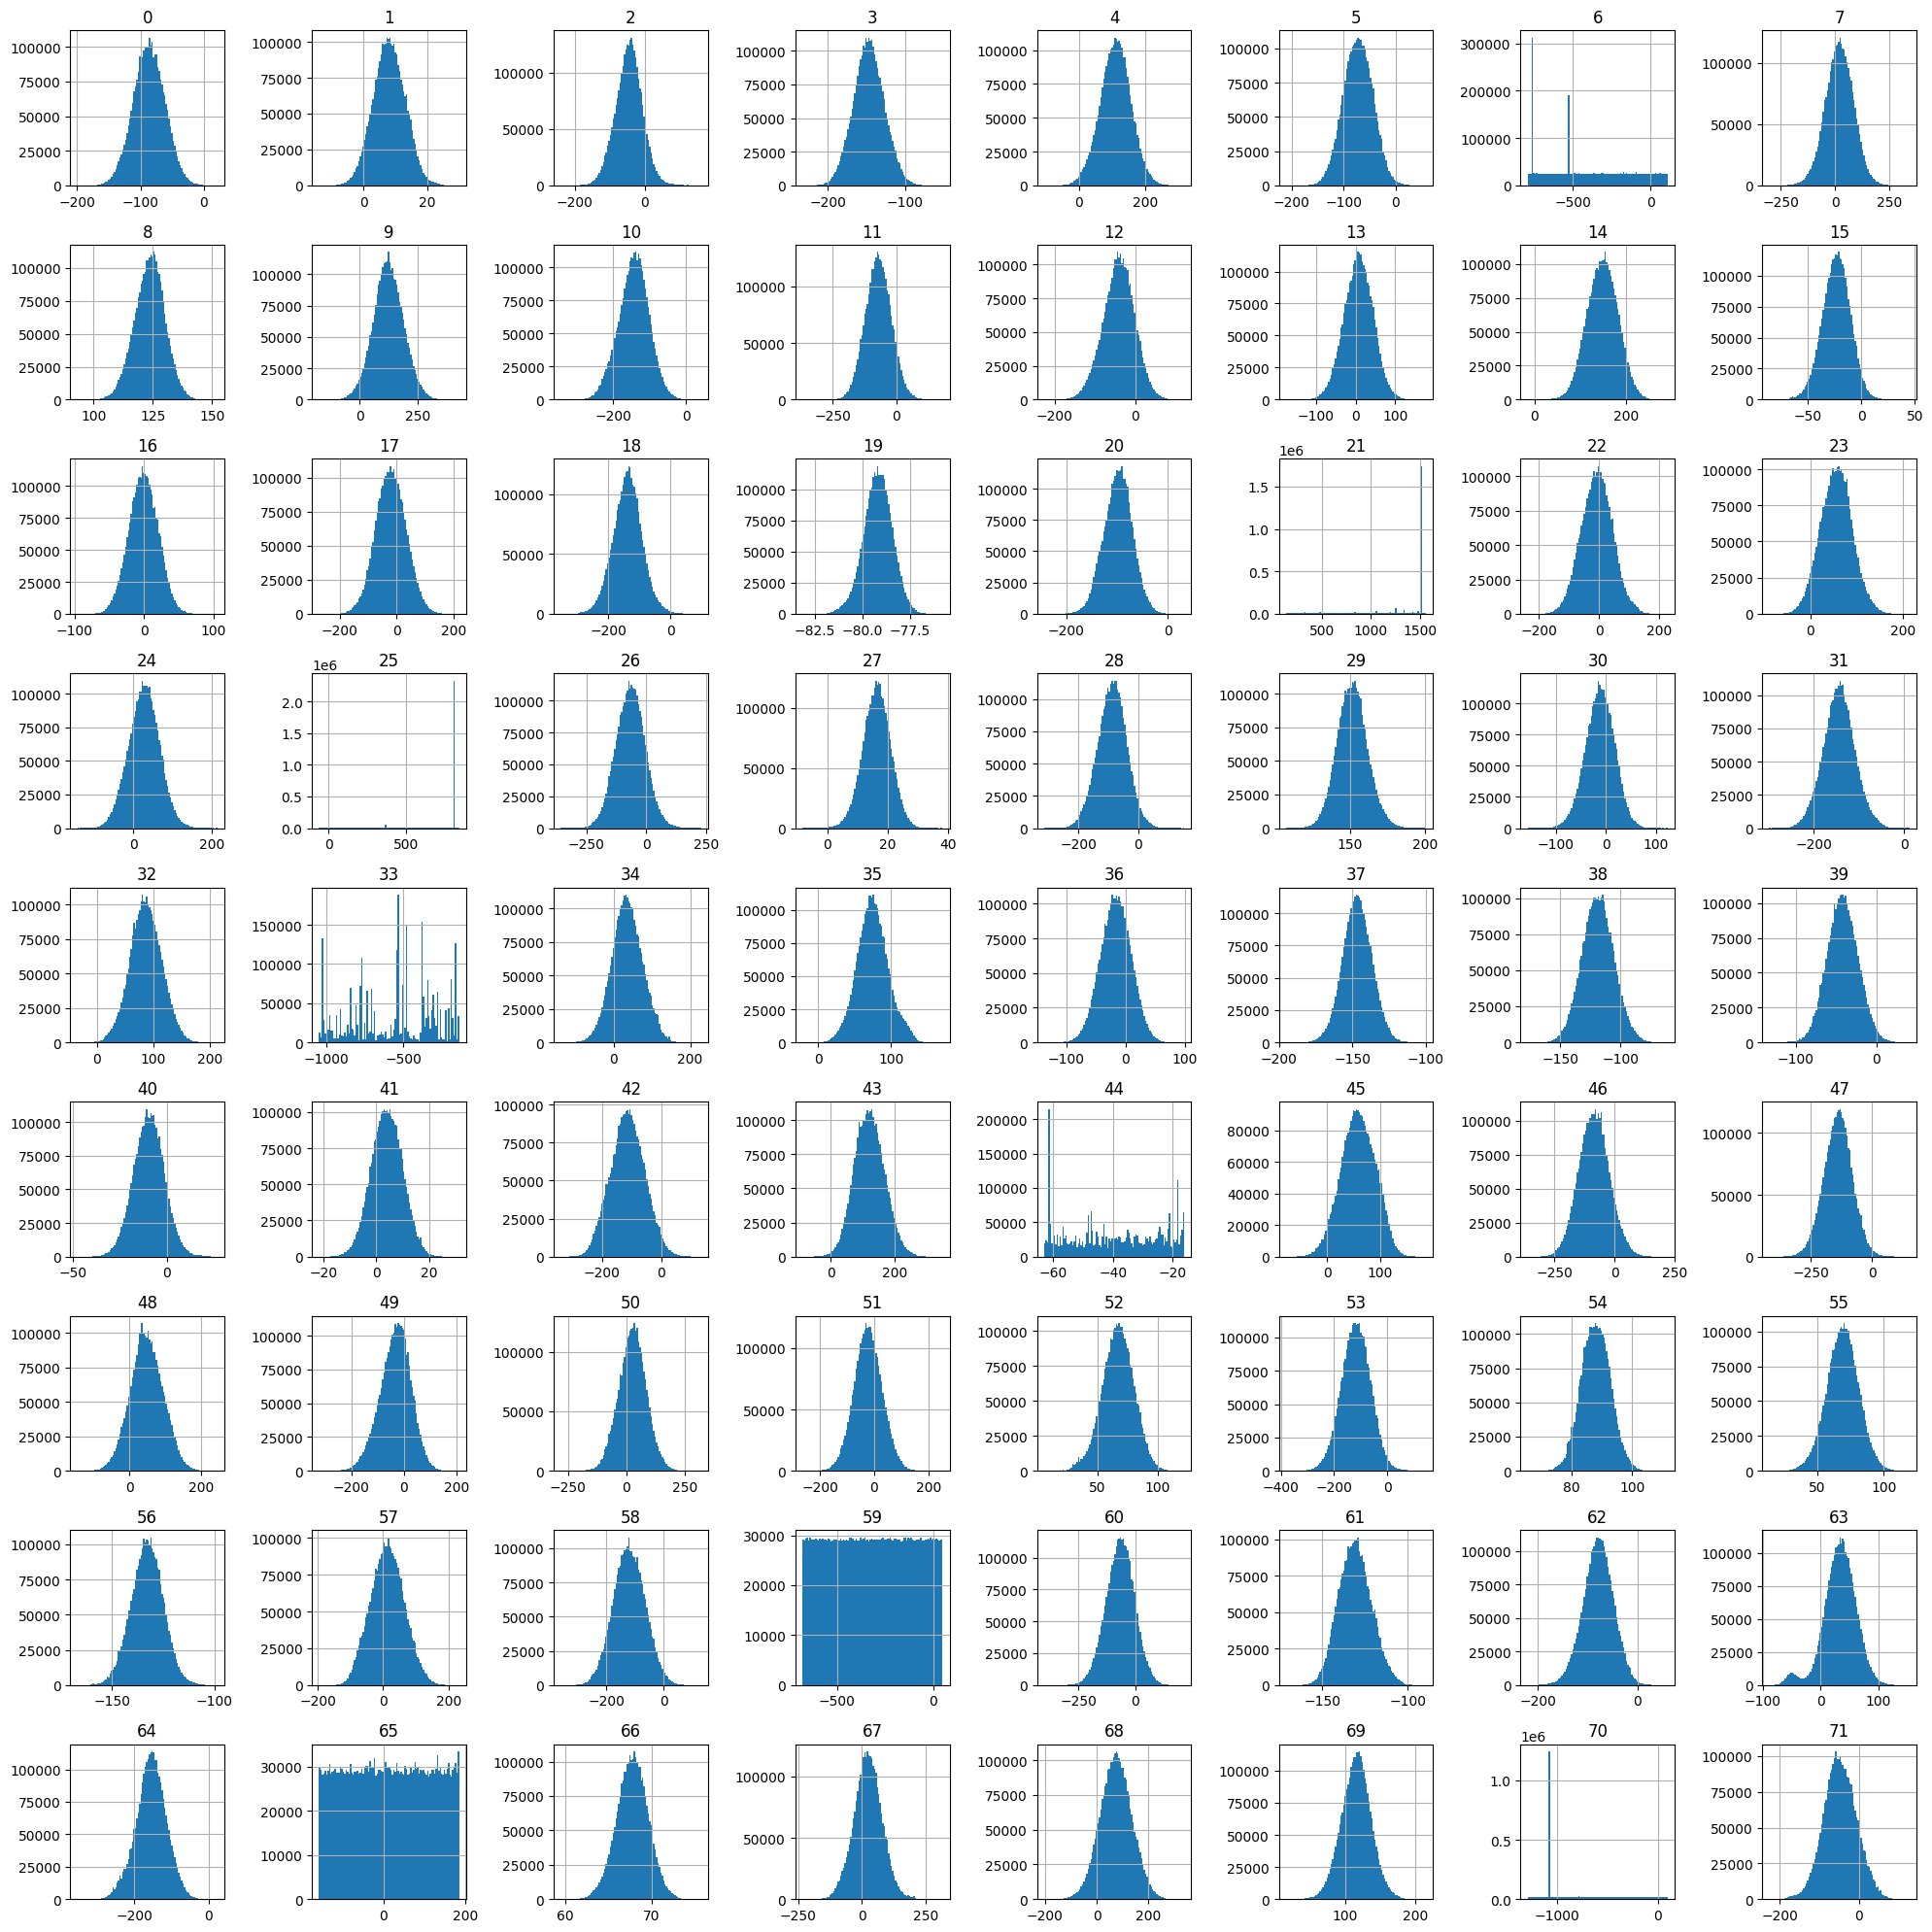

In [13]:
plt.rcParams['figure.figsize'] = (20,20)
base.hist(bins=100)
plt.tight_layout()
plt.show()

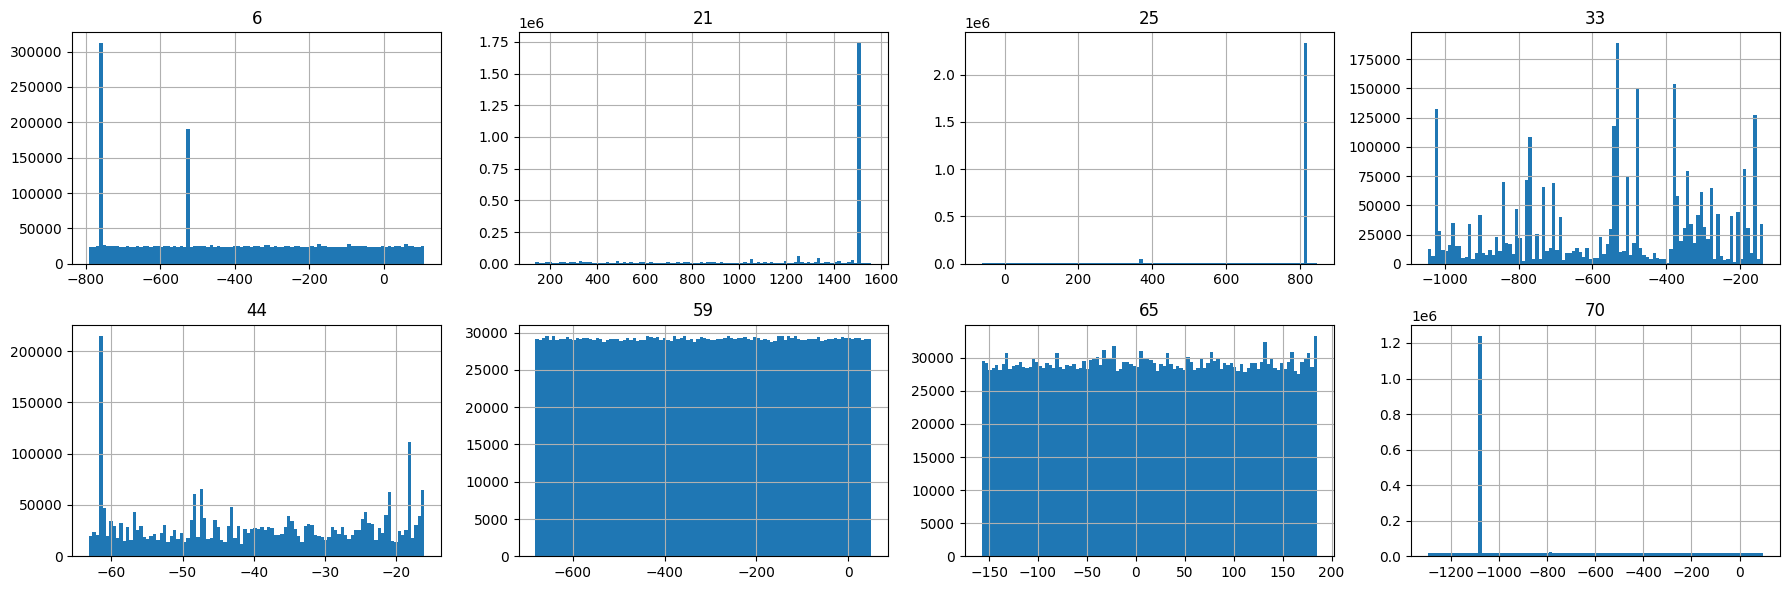

In [14]:
subset_cols = ['6', '21', '25', '33', '44', '59', '65', '70']
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (18,6))
base[subset_cols].hist(bins = 100, ax = ax)
plt.tight_layout()
plt.show()

В процессе первичного визуального анализа распределения признаков установлено:
* всего в исходных данных 72 поля с численными признаками;
* 64 признака имеют распределение близкое к нормальному, 8 признаков имеют другие виды распределений;
* у некоторых не нормально распределённых признаков есть значения, встречающиеся чаще других.

## Подготовка данных

In [15]:
# X_test, base already exist
X_train = train.loc[:, train.columns[:-1]]
y_train = train.loc[:, train.columns[-1]]
del train

В качестве прдобработки данных выполним их стандартизацию - центрируем все признаки относительно мат. ожидания и масштабируем по ср. кв. отклонению:

In [16]:
# Центрирование и масштабирование данных
scaler = StandardScaler()
scaler.fit(base.values)
base.loc[:, base.columns] = scaler.transform(base.values)
X_train.loc[:, X_train.columns] = scaler.transform(X_train.values)
X_test.loc[:, X_test.columns] = scaler.transform(X_test.values)

## Baseline на обучающей выборке

In [17]:
%%time
topn = 10
index = create_index(vectors = base.values, nlist = 100, nprobe = 5)
D, I = index.search(X_train.values, topn)
id_pred = get_base_id(idx_pred = I, base_id = base.index)
depth_pred = get_search_depthwise(id_pred = id_pred, y_true = y_train)
print('Recall@1:', round(depth_pred[:, 0].mean(), 5))
print(f'Recall@{topn}: {round(depth_pred.mean()*topn, 5)}')

Recall@1: 0.48716
Recall@10: 0.63387
CPU times: user 4min 25s, sys: 692 ms, total: 4min 26s
Wall time: 1min 12s


In [18]:
dist_train = L2_dist(X_train.values, base.loc[y_train.values].values, depth_pred[:, 0])
print(f'Среднее расстояние между векторами из обучающего набора: {round(np.mean(dist_train[:, -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой true: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 1), -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой false: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 0), -2]), 3)}')

Среднее расстояние между векторами из обучающего набора: 4.738
Среднее расстояние между векторами с меткой true: 2.66
Среднее расстояние между векторами с меткой false: 6.713


Признак расстояния я не использовал для обучения модели, но с помощью этой характеристики я оцениваю некторые изменения, которые произвожу с исходными данными. Обратите внимание, что расстояния от искомых объектов до объектов, которым найдено соответствие значительно меньше, чем до объектов, которым соответствие не найдено.

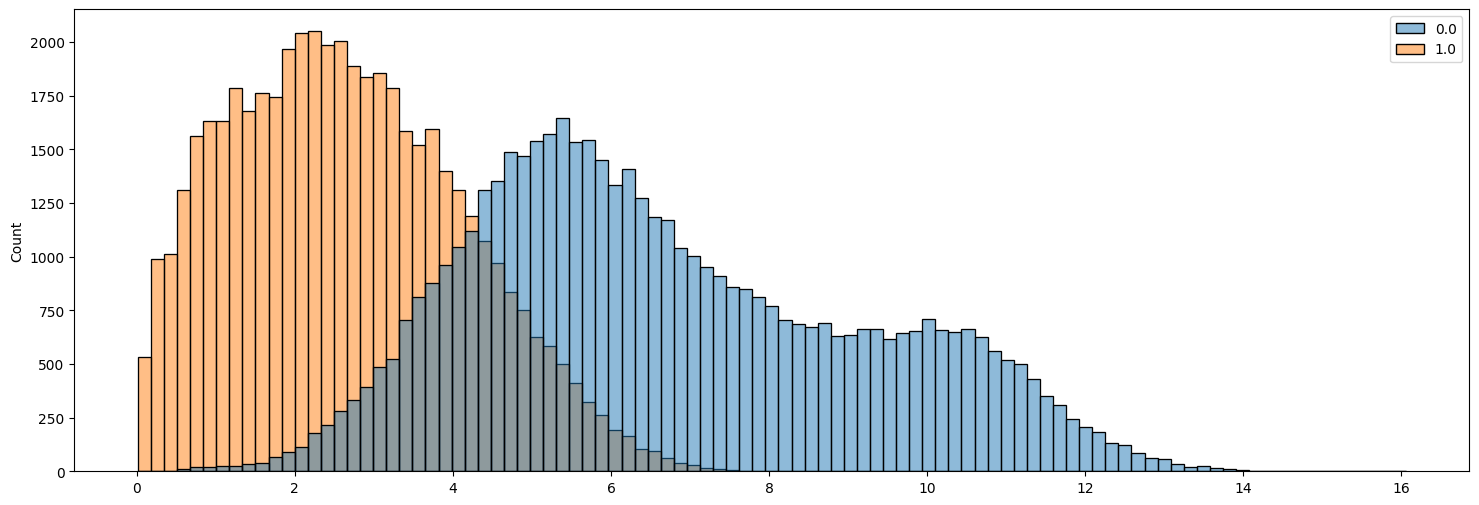

In [19]:
plt.rcParams['figure.figsize'] = (18,6)
sns.histplot(data = dist_train, x = dist_train[:, -2], hue = dist_train[:, -1])
plt.show()

Гистограммы распределения говорят, что есть много объектов, которые расположены близко, но их не находят. Вероятно, это вливние т.н. "мусорных" признаков.

Далее, посмотрим какие признаки вносят наибольший вклад в расстояние между объектами:

In [20]:
total = np.array([round(np.mean(dist_train[:, col]), 4) for col in range(len(X_train.columns))])
true = np.array([round(np.mean(dist_train[np.where((dist_train[:, -1] == 1) & (dist_train[:, -2] != 0)), col]), 4) for col in range(len(X_train.columns))])
false = np.array([round(np.mean(dist_train[np.where((dist_train[:, -1] == 0) & (dist_train[:, -2] != 0)), col]), 4) for col in range(len(X_train.columns))])
top_strong = 10
for arr in [(total, 'Всего по обучающему набору:'), (true, 'C меткой true:'), (false, 'С меткой false:')]:
    print(f'\n{arr[1]}')
    for idx in np.argsort(arr[0])[-top_strong:]:
        print(f'{idx}: {arr[0][idx]}')


Всего по обучающему набору:
23: 0.0032
51: 0.0032
70: 0.0149
44: 0.0164
6: 0.0172
25: 0.0217
65: 0.0309
21: 0.0316
33: 0.113
59: 0.1509

C меткой true:
0: 0.0012
47: 0.0013
70: 0.0142
25: 0.0157
44: 0.0167
6: 0.0186
65: 0.0297
21: 0.0361
33: 0.1768
59: 0.2653

С меткой false:
51: 0.0051
18: 0.0051
70: 0.0156
6: 0.0159
44: 0.0162
21: 0.0273
25: 0.0274
65: 0.032
59: 0.0423
33: 0.0525


Признаки, на которые мы уже ранее обращали внимание из-за формы их распределения вносят значительно больший вклад в расстояние, чем остальные (возможно они являются разделяющими, например - это крупные группы/подгруппы объектов). Попробуем их исключить и провести поиск повторно.

## Поиск по сокращенному набору признаков (Recall@10 на тестовой выборке = 0.73730)

Исключим признаки, распределение которых не нормальное и снова выполним поиск:

In [21]:
not_normed_cols = ['6', '21', '25', '33', '44', '59', '65', '70']
normed_cols = [col for col in X_train.columns if col not in not_normed_cols]

In [22]:
%%time
topn = 10
index = create_index(vectors = base[normed_cols].values, nlist = 100, nprobe = 5)
D, I = index.search(X_train[normed_cols].values, topn) 
id_pred = get_base_id(idx_pred = I, base_id = base.index)
depth_pred = get_search_depthwise(id_pred = id_pred, y_true = y_train)
print('Recall@1:', round(depth_pred[:, 0].mean(), 5))
print(f'Recall@{topn}: {round(depth_pred.mean()*topn, 5)}')

Recall@1: 0.57622
Recall@10: 0.6948
CPU times: user 3min 41s, sys: 1.19 s, total: 3min 43s
Wall time: 1min 2s


In [23]:
dist_train = L2_dist(X_train[normed_cols].values, base.loc[y_train.values, normed_cols].values, depth_pred[:, 0])
print(f'Среднее расстояние между векторами из обучающего набора: {round(np.mean(dist_train[:, -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой true: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 1), -2]), 3)}')
print(f'Среднее расстояние между векторами с меткой false: {round(np.mean(dist_train[np.where(dist_train[:, -1] == 0), -2]), 3)}')

Среднее расстояние между векторами из обучающего набора: 3.128
Среднее расстояние между векторами с меткой true: 1.004
Среднее расстояние между векторами с меткой false: 6.016


Среднее расстояние уменьшилось, однако для тех, которым находится соответствие больше. Тоже хороший результат, посмотрим на распределение расстояний:

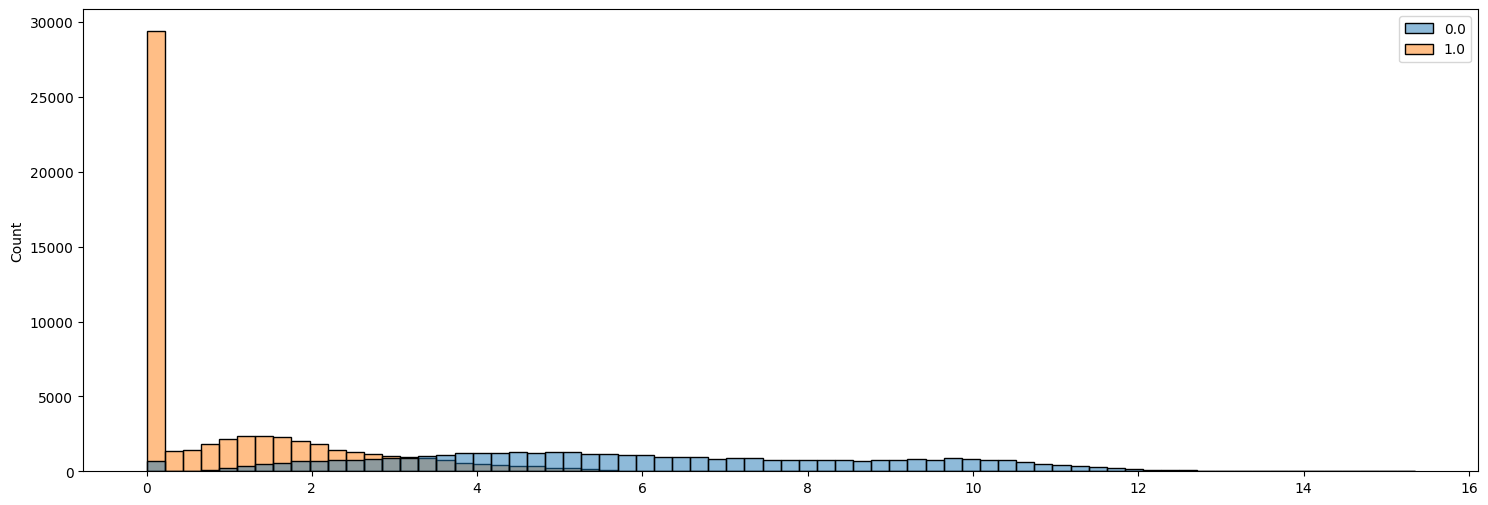

In [24]:
plt.rcParams['figure.figsize'] = (18,6)
sns.histplot(data = dist_train, x = dist_train[:, -2], hue = dist_train[:, -1])
plt.show()

Объектов, расстояние от которых до искомого объекта близко нулю стало значительно больше, но среди них также есть и те, которые не первые в выдаче.

**ВАЖНО:** на данный момент признаки обработаны StandardScaler, признаки имеющие не нормальное распределение исключены из поиска - этого достаточно, чтобы на тестовой выборке показать результат Recall@10 = 0.73730 и занять 5-е место.

## Многоступенчатый поиск по нескольким индексам (Recall@10 на тестовой выборке = 0.75970)

Следующие преобразования я тестировал после закрытия соревнования в Late submission. Идея заключается в том, что некоторые признаки (в частности те, которые распределены не номрально) по одиночке показывают высокий Recall@10 и их можно использовать как самостоятельный индекс. Данный подход позволяет:
* **на 2% увеличить метрику Recall@10** на тестовом сете;
* **в 3 раза увеличить скорость поиска** (сравните поиск на 100К записей тренировочного сета в ячейке [22] и поиск на 100К записей тестового сета в ячейке [36]).

Эту задачу также можно представить не в виде задачи классификации, а в виде задачи регрессии, если классы представить в виде матрицы бинарных состояний, а выбор производить по наибольшему значению, предсказанному моделью (что-то похожее на predict_proba). Возможно это улучшит метрику и позволит относить объекты к определенным индексам более качественно.

In [25]:
file_name = 'single_feature_recall.csv'
if not os.path.isfile(file_name) or RECOUNT_NOTEBOOK:
    topn = 100
    single_feature_recall = pd.DataFrame(columns = ['Recall@1', 'Recall@10', 'Recall@100'], index = base.columns)

    for col in base.columns:
        del index, D, I, coord_pred, depth_pred, id_pred
        index = create_index(vectors = base[[col]].values, nlist = 100, nprobe = 2)
        D, I = index.search(X_train[[col]].values, topn)
        id_pred = get_base_id(idx_pred = I, base_id = base.index)
        depth_pred = get_search_depthwise(id_pred = id_pred, y_true = y_train)
        single_feature_recall.loc[col] = [depth_pred[:, 0].mean(), depth_pred[:, :10].mean()*10, depth_pred.mean()*topn]
        print(f'{col}: Recall@1 = {depth_pred[:, 0].mean():.3f}, Recall@10 = {depth_pred[:, :10].mean()*10:.3f}, Recall@{topn} = {depth_pred.mean()*topn:.3f}')
    single_feature_recall.to_csv('single_feature_recall.csv')
else:
    single_feature_recall = pd.read_csv(file_name, index_col = 'Unnamed: 0')

In [26]:
display(single_feature_recall.head(10))
print(f"Avg. Recall@1: {round(single_feature_recall['Recall@1'].mean(), 5)}")

,Recall@1,Recall@10,Recall@100
0,0.16872,0.19382,0.24144
1,0.17241,0.19452,0.24188
2,0.17355,0.19355,0.24079
3,0.15766,0.19454,0.24244
4,0.17083,0.19459,0.24146
5,0.16969,0.19409,0.24132
6,0.41492,0.45801,0.45900
7,0.17484,0.19384,0.24081
8,0.14269,0.19436,0.24030
9,0.17187,0.19433,0.24170


Avg. Recall@1: 0.1661


In [27]:
subset_cols = ['6', '21', '25', '33', '44', '59', '65', '70']
display(single_feature_recall.loc[[int(x) for x in subset_cols]].sort_values(by = 'Recall@1', ascending = False))

,Recall@1,Recall@10,Recall@100
70,0.56915,0.60700,0.60706
6,0.41492,0.45801,0.45900
65,0.28173,0.29100,0.29235
21,0.03633,0.04838,0.06623
25,0.03194,0.03391,0.03535
44,0.01999,0.10429,0.27654
33,0.00000,0.00000,0.00001
59,0.00000,0.00000,0.00001


В среднем Recall@1 = 0.1661 и некоторые признаки, имеюшие не нормальное распределение показывают значительно лучшие результаты. Среди индексов явно выделяются 33-й и 59-й - это явно шум, который не несет никакой информации. Выполним многоступенчатое индексирование: объекты найденные по одиночному индексу с найибольшим Recall@1 помечаются и не участвуют в дальнейшем поиске - это ускоряет работу алкгоритма в 3 раза (незаметно сейчас, т.к. мы формируем обучающий набор для ML, но это явно видно на работе с тестовой выборкой):

In [28]:
index_cols = [['70'], ['6'], ['65'], ['21'], ['25'], ['44']]
map_idxs = [(idx_num + 1, index_cols[idx_num]) for idx_num in range(len(index_cols))]
for index in map_idxs:
    print(index)

(1, ['70'])
(2, ['6'])
(3, ['65'])
(4, ['21'])
(5, ['25'])
(6, ['44'])


In [29]:
%%time
topn = 1
target_ml = pd.Series(index = X_train.index, data = np.zeros(X_train.shape[0]), dtype = int)
for label, index_cols in map_idxs:
    mask = (target_ml == 0) # создаем маску для объектов, которым не найдено соответствие
    index = create_index(vectors = base[index_cols].values, nlist = 100, nprobe = 5)
    _, I = index.search(X_train.loc[mask, index_cols].values, topn)
    id_pred = get_base_id(idx_pred = I, base_id = base.index)
    marked_pred = (id_pred.flatten() == y_train[mask].values).astype('int')*label # отмечаем совпавшие объекты
    target_ml[mask] = marked_pred

CPU times: user 11min 13s, sys: 261 ms, total: 11min 13s
Wall time: 2min 54s


In [30]:
values, counts = np.unique(target_ml.values, return_counts = True)
for i in range(values.shape[0]):
    print(values[i], counts[i])

0 21533
1 56915
2 17903
3 3229
4 53
5 275
6 92


In [31]:
%%time
clf = RandomForestClassifier(n_estimators = 100, random_state = RANDOM_SEED, n_jobs = -1)
y_pred_cv = cross_val_predict(clf, X_train, target_ml, cv = 5, n_jobs = -1)
score = accuracy_score(target_ml, y_pred_cv)
print('Точность: %.2f%%' % (score * 100))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Точность: 71.55%
CPU times: user 250 ms, sys: 139 ms, total: 389 ms
Wall time: 3min 26s


In [32]:
values, counts = np.unique(y_pred_cv, return_counts = True)
for i in range(values.shape[0]):
    print(values[i], counts[i])

0 12349
1 76311
2 11130
3 199
4 3
5 2
6 6


Модель явно пытается пометить все 1-м лейблом, что в теории можно отрегулировать threshhold-ом. Посмотрим матрицу ошибок:

Точность: 71.50%


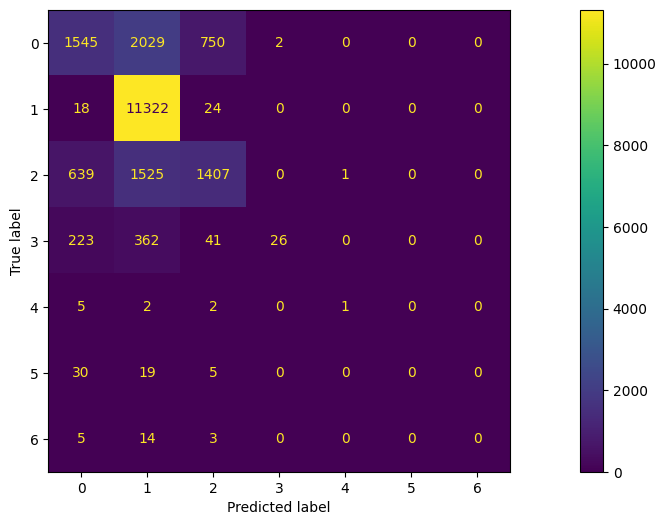

In [33]:
obj_train, obj_test, target_train, target_test = train_test_split(X_train, target_ml, test_size = 0.2, random_state = RANDOM_SEED)
# Обучение классификатора
clf.fit(obj_train, target_train)

# Прогнозирование меток классов для тестовых данных
y_pred = clf.predict(obj_test)

# Вычисление точности предсказания
accuracy = accuracy_score(target_test, y_pred)
print('Точность: %.2f%%' % (accuracy * 100))
cm = confusion_matrix(target_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=clf.classes_).plot()

In [34]:
topn = 10
id_pred = np.empty((X_train.shape[0], topn), dtype = object)

for idx in np.unique(y_pred_cv):
    if idx == 0:
        cols = normed_cols
    else:
        cols = map_idxs[idx - 1][1]
    index = create_index(vectors = base[cols].values, nlist = 100, nprobe = 5)
    mask = (y_pred_cv == idx)
    _, I = index.search(X_train.loc[mask, cols].values, topn)
    id_pred[mask] = get_base_id(idx_pred = I, base_id = base.index)
depth_pred = get_search_depthwise(id_pred = id_pred, y_true = y_train)
print('Recall@1:', round(depth_pred[:, 0].mean(), 5))
print(f'Recall@{topn}: {round(depth_pred.mean()*topn, 5)}')

Recall@1: 0.69626
Recall@10: 0.75851


## Формирование тестовой выгрузки

In [35]:
clf = RandomForestClassifier(n_estimators = 100, random_state = RANDOM_SEED, n_jobs = -1)
clf.fit(X_train, target_ml)

RandomForestClassifier(n_jobs=-1, random_state=12345)

In [36]:
%%time
y_pred_test = clf.predict(X_test)
topn = 10
id_pred_test = np.empty((X_test.shape[0], topn), dtype = object)

for idx in np.unique(y_pred_test):
    if idx == 0:
        cols = normed_cols
    else:
        cols = map_idxs[idx - 1][1]
    index = create_index(vectors = base[cols].values, nlist = 100, nprobe = 5)
    mask = (y_pred_test == idx)
    _, I = index.search(X_test.loc[mask, cols].values, topn)
    id_pred_test[mask] = get_base_id(idx_pred = I, base_id = base.index)

CPU times: user 1min 4s, sys: 635 ms, total: 1min 5s
Wall time: 19.5 s


Поиск на обученной модели - 19.5с. Для сравнения аналогичный поиск без предварительной классификации на тренировочном сете - 1м 2с!

In [37]:
answers_df = pd.DataFrame(columns = ['Predicted'], index = X_test.index)
for row in range(X_test.shape[0]):
    answers_df.iloc[row, 0] = ' '.join(id_pred_test[row].tolist())
    print(f'\r{row + 1}/100000', end = '')
answers_df.reset_index(inplace = True)
display(answers_df.head())

100000/100000

,Id,Predicted
0,100000-query,2676668-base 2591807-base 4452463-base 530728-...
1,100001-query,76638-base 2689596-base 4483875-base 2756087-b...
2,100002-query,472256-base 3793446-base 21618-base 289468-bas...
3,100003-query,25566-base 75422-base 88407-base 96608-base 11...
4,100004-query,75484-base 1312535-base 1966570-base 227092-ba...


In [38]:
answers_df.to_csv('my_submission_11.csv', index=False)

# Выводы

В данном проекте перед нами стояла задача решить усеченную задачу матчинга - найти в базе (base) 10 объектов близких по признакам 1 объекту из запроса (query). В качестве метрики выступала Recall@10: для каждого товара найти 10 наиболее близких кандидатов. Тогда:

**Recall@10 = (общая сумма найденных в топ10 матчей) / (общая сумма матчей)**

Данные были представлены в векторном виде, все поля закодированы числами. С помощью минимальной предобработки StandardScaler'ом и исключения признаков с не нормальным распределением удалось добиться хорошего результата **Recall@10 = 0.73730**. Предварительная классификация объектов и многоступенчатый поиск по нескольким индексам позволил:
* **на 2% увеличить метрику Recall@10** (до 0.75970);
* **в 3 раза увеличить скорость поиска**.

**Что можно сделать, чтобы улучшить результат?**

🌱 Заменить RandomForest на что-то лучшее (посмотреть в сторону бустинговых моделей), подобрать гиперпараметры;

🌱 Подобрать лучшие пороги для классификации к какому индексу относить объекты;

🌱 Перейти от задачи классификации к задаче регрессии, если классы представить в виде матрицы бинарных состояний;

🌱 Добавить реранкинг с помощью ML (ссылка для ознакомления ниже).